# Evaluation/Testing

In [2]:
import pickle
import torch
import pandas as pd
import torch.nn as nn
import numpy as np

import scripts.data_loader as data_loader
import src.training as training
import src.evaluation as evaluation

from dataclasses import dataclass, asdict
from src.types import * 
from src.models.model1 import OB_05Model


cm = ConfusionMatrx
cm_macro = ConfusionMatrx.Macro
cm_micro = ConfusionMatrx.Micro


with open("models/training_logger.pkl", "rb") as file:
    training_logger = pickle.load(file)

print(training_logger)

TrainingLogger(training_confusion_matrix_history=[array([[181, 130,  62,  52],
       [139, 106,  65,  40],
       [ 18,  46, 250, 122],
       [ 18,  58, 190, 143]]), array([[294, 110,   6,  15],
       [173, 147,   9,  21],
       [  7,  13, 286, 130],
       [  3,  13, 124, 269]]), array([[290, 116,   1,  18],
       [143, 185,  12,  10],
       [  2,  11, 341,  82],
       [  8,   6, 113, 282]]), array([[274, 136,   3,  12],
       [128, 200,   9,  13],
       [  4,  11, 343,  78],
       [ 11,   6,  81, 311]]), array([[309, 104,   4,   8],
       [142, 185,  12,  11],
       [  1,   4, 358,  73],
       [  7,   4,  58, 340]]), array([[315,  96,   3,  11],
       [129, 197,  10,  14],
       [  2,   7, 370,  57],
       [  6,   6,  60, 337]]), array([[326,  92,   3,   4],
       [129, 201,   7,  13],
       [  2,   4, 387,  43],
       [  6,   8,  49, 346]]), array([[335,  84,   3,   3],
       [102, 228,   5,  15],
       [  3,   5, 379,  49],
       [  3,   3,  57, 346]]), array(

In [3]:
loaded_testing_dataset = torch.load('models/testing_dataset.pth')
testing_set_loader = data_loader.create_data_loader(loaded_testing_dataset)

print(next(iter(loaded_testing_dataset)))

(tensor([[[ 1.0395,  0.9886,  0.9377,  0.9123,  0.8359,  0.8104,  0.8104,
           0.8104,  0.8359,  0.8232,  0.7850,  0.8359,  0.8359,  0.8232,
           0.8232,  0.8486,  0.8359,  0.9377,  1.1159,  1.0904,  0.8613,
           0.5177,  0.5559,  0.6704,  0.6195,  0.3904,  0.2122,  0.1104],
         [ 1.0395,  1.0013,  0.9886,  0.9377,  0.8613,  0.8613,  0.8741,
           0.8868,  0.9250,  0.9759,  0.9377,  0.9250,  0.8232,  0.9886,
           1.0268,  0.8995,  0.8613,  0.9632,  1.1032,  1.0904,  0.8359,
           0.4922,  0.5177,  0.6195,  0.5559,  0.3522,  0.2758,  0.1740],
         [ 1.0523,  1.0268,  1.0141,  1.0141,  0.9377,  0.8868,  0.8359,
           0.8741,  0.7595,  0.7086,  0.7850,  0.9886,  0.8741,  0.8995,
           0.9886,  1.0395,  1.0141,  0.9886,  1.1286,  1.1032,  0.8359,
           0.5177,  0.5049,  0.5686,  0.5049,  0.4031,  0.3777,  0.3013],
         [ 1.0904,  1.0523,  1.0013,  1.0268,  0.9250,  0.6959,  0.7086,
           0.7722,  0.9377,  1.0141,  1.3450,  

In [4]:
model = OB_05Model()
model.load_state_dict(torch.load('models/model.pth'))
evaluation_result = evaluation.evaluate_model(model, testing_set_loader)

#### Macro/Micro metrics

In [5]:
confusion_matrix = evaluation_result.confusion_matrix

macro_precision, macro_recall, macro_f1_score, macro_accuracy = cm_macro.calculate_overall_metrics(confusion_matrix)
micro_precision, micro_recall, micro_f1_score, micro_accuracy = cm_micro.calculate_overall_metrics(confusion_matrix)
accuracy = (macro_accuracy + micro_accuracy) / 2  # should be the same for both

data = [[macro_precision, macro_recall, macro_f1_score, micro_precision, micro_recall, micro_f1_score, accuracy]]
tuples = [("macro", "precision"), ("macro", "recall"), ("macro", "f1_score"), ("micro", "precision"), ("micro", "recall"), ("micro", "f1_score"), ("", "accuracy")]

df = pd.DataFrame(data,
                  index=pd.Index(["model"]),
                  columns=pd.MultiIndex.from_tuples(tuples, names=["", "metrics"]))
s = df.style

s

#### Confusion matrix

In [6]:
confusion_matrix = evaluation_result.confusion_matrix

df = pd.DataFrame(confusion_matrix,
                  index=pd.Index(["anger", "engaged", "happy", "neutral"]),
                  columns=pd.Index(["anger", "engaged", "happy", "neutral"]))
s = df.style
s

,anger,engaged,happy,neutral
anger,81,13,0,0
engaged,25,38,0,1
happy,1,0,84,5
neutral,4,1,8,87


#### Confusion matrix analysis

In [7]:
confusion_matrix = evaluation_result.confusion_matrix

precisions, recalls, f1_scores, accuracies = cm.calculate_per_class_metrics(confusion_matrix)
array = [precisions, recalls, f1_scores, accuracies]

df = pd.DataFrame(array, 
                  index=pd.Index(["precision", "recall", "f1_score", "accuracy"]),
                  columns=pd.Index(["anger", "engaged", "happy", "neutral"]))
df

,anger,engaged,happy,neutral
precision,0.729730,0.730769,0.913043,0.935484
recall,0.861702,0.593750,0.933333,0.870000
f1_score,0.790244,0.655172,0.923077,0.901554
accuracy,0.876437,0.885057,0.959770,0.945402


In [8]:
import seaborn as sns

from pipe import *


def process_metrics(_data, metric_name):
    as_df = pd.DataFrame(_data, columns=["score"])
    as_df.insert(0, "class", ["anger", "engaged", "happy", "neutral"])
    as_df.insert(1, "metric", metric_name)
    # as_df[metric_name] = metric_name
    return as_df 

precisions, recalls, f1_scores, accuracies = cm.calculate_per_class_metrics(confusion_matrix)

processed_precisions = process_metrics(precisions, "precision")
processed_recalls = process_metrics(recalls, "recall")
processed_f1_scores = process_metrics(f1_scores, "f1_score")
processed_accuracies = process_metrics(accuracies, "accuracy")

df = pd.concat([processed_precisions, processed_recalls, processed_f1_scores, processed_accuracies])
df

,class,metric,score
0,anger,precision,0.729730
1,engaged,precision,0.730769
2,happy,precision,0.913043
3,neutral,precision,0.935484
0,anger,recall,0.861702
1,engaged,recall,0.593750
2,happy,recall,0.933333
3,neutral,recall,0.870000
0,anger,f1_score,0.790244
1,engaged,f1_score,0.655172


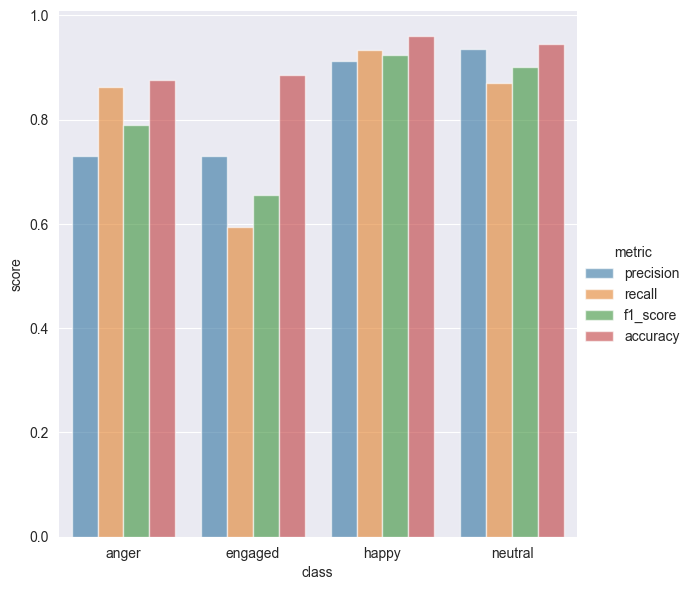

In [9]:
g = sns.catplot(df, kind="bar", x="class", y="score", hue="metric",
                errorbar="sd", alpha=0.6, height=6)
g.despine(left=True, bottom=True)
g.legend.set_title("metric")